In [1]:
## Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [2]:
# Generate dummy "normal" data (cluster) and "anomalous" data (outliers)
np.random.seed(42)
normal_data = np.random.randn(150, 2) * 0.5 + [0, 0]  # Cluster around origin
outliers_data = np.random.uniform(low=-3, high=3, size=(50, 2)) # Scattered outliers
X = np.concatenate([normal_data, outliers_data]) # Combine
y = np.concatenate([np.ones(150), -np.ones(50)]) # 1 for normal, -1 for outlier (for evaluation, not used in training)
X_df = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y_series = pd.Series(y)

# Split data into training and testing sets (Crucial: train only on 'normal' data for OneClassSVM)
X_train = X_df[y_series == 1] # Training set is ONLY 'normal' data
X_test = X_df # Test set contains both 'normal' and 'anomalous' data
y_test = y_series # Test labels (for evaluation, not used in OneClassSVM training)

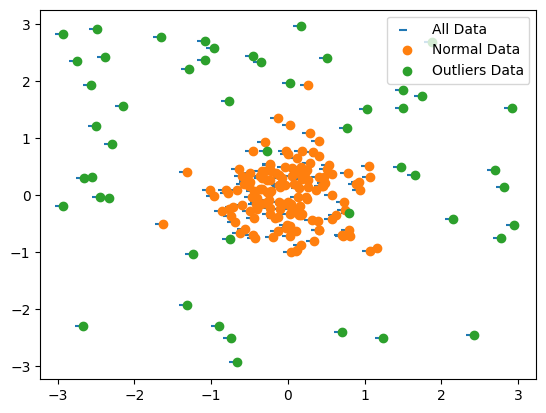

In [3]:
## Scatter plot of data points
plt.scatter(*zip(*X_df.to_numpy()),marker=0)
plt.scatter(*zip(*normal_data))
plt.scatter(*zip(*outliers_data))
plt.legend(["All Data", "Normal Data", "Outliers Data"])

In [4]:
# Scale the data using StandardScaler (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit scaler on TRAINING data ONLY
X_test_scaled = scaler.transform(X_test) # Apply scaler to TEST data

print("Dummy Training Data (first 5 rows of scaled normal features):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())
print("\nDummy Test Data (first 5 rows of scaled features - includes normal and anomalous):")
print(pd.DataFrame(X_test_scaled, columns=X_test.columns).head())

Dummy Training Data (first 5 rows of scaled normal features):
   feature_1  feature_2
0   0.550082  -0.161377
1   0.706548   1.501451
2  -0.207371  -0.257338
3   1.671957   0.745159
4  -0.451252   0.520076

Dummy Test Data (first 5 rows of scaled features - includes normal and anomalous):
   feature_1  feature_2
0   0.550082  -0.161377
1   0.706548   1.501451
2  -0.207371  -0.257338
3   1.671957   0.745159
4  -0.451252   0.520076


In [5]:
# Initialize and fit OneClassSVM model
nu_value = 0.1 # nu parameter (fraction of outliers expected/allowed)
gamma_value = 'auto' # gamma parameter for RBF kernel ('scale' or 'auto' often good starting points, or float value)

oneclass_svm = OneClassSVM(kernel='rbf', nu=nu_value, gamma=gamma_value) # RBF kernel is common, tune kernel and nu/gamma
oneclass_svm.fit(X_train_scaled) # IMPORTANT: Fit ONLY on the scaled TRAINING data (normal data)

# Get predictions (1 for normal, -1 for outlier) on the TEST set
y_pred_test = oneclass_svm.predict(X_test_scaled)
X_test_labeled = X_test.copy()
X_test_labeled['prediction'] = y_pred_test # Add predictions to test DataFrame

# Get decision function values (raw scores, useful for thresholding and ranking anomalies)
decision_scores_test = oneclass_svm.decision_function(X_test_scaled)
X_test_labeled['decision_score'] = decision_scores_test # Add decision scores

print("\nPredictions (first 10):\n", y_pred_test[:10])
print("\nDecision Scores (first 10):\n", decision_scores_test[:10])


Predictions (first 10):
 [ 1  1  1  1  1  1  1 -1  1  1]

Decision Scores (first 10):
 [ 0.00118924  0.09482545  0.02152039  0.19006689  0.02197238  0.06130406
  0.02692327 -0.00024873  0.02203976  0.0191339 ]


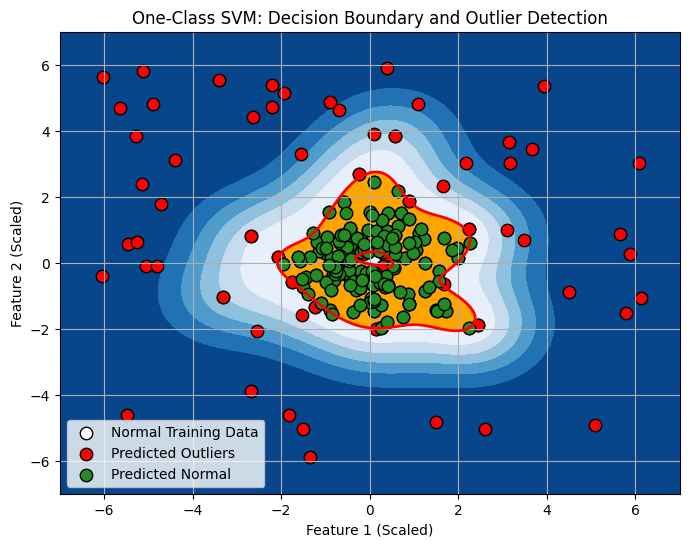

In [6]:
# Visualize decision boundary and outliers (for 2D data)
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500)) # Create grid for plotting boundary
Z = oneclass_svm.decision_function(np.c_[xx.ravel(), yy.ravel()]) # Get decision function values for grid
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r) # Contour for negative scores (outlier region)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red') # Contour at 0 decision function (boundary)
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange') # Contour for positive scores (normal region)

s = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], color='white', s=20*4, edgecolors='k', label="Normal Training Data") # Normal training data (white)
b = plt.scatter(X_test_scaled[y_pred_test == -1, 0], X_test_scaled[y_pred_test == -1, 1], color='red', s=20*4, edgecolors='k', label="Predicted Outliers") # Predicted outliers (red)
c = plt.scatter(X_test_scaled[y_pred_test == 1, 0], X_test_scaled[y_pred_test == 1, 1], color='forestgreen', s=20*4, edgecolors='k', label="Predicted Normal") # Predicted normal (green)

plt.title('One-Class SVM: Decision Boundary and Outlier Detection')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import pickle

# Save the scaler
with open('standard_scaler_oneclasssvm.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the OneClassSVM model
with open('oneclass_svm_model.pkl', 'wb') as f:
    pickle.dump(oneclass_svm, f)

print("\nScaler and One-Class SVM Model saved!")

# --- Later, to load ---

# Load the scaler
with open('standard_scaler_oneclasssvm.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Load the OneClassSVM model
with open('oneclass_svm_model.pkl', 'rb') as f:
    loaded_oneclass_svm = pickle.load(f)

print("\nScaler and One-Class SVM Model loaded!")


Scaler and One-Class SVM Model saved!

Scaler and One-Class SVM Model loaded!


In [8]:
loaded_oneclass_svm.predict([[0.1,0.1]])

array([-1])

In [9]:
# Calculate decision scores on training data (normal data)
decision_scores_train = oneclass_svm.decision_function(X_train_scaled)

# Set threshold based on a percentile of training data scores (e.g., 5th percentile)
threshold_percentile = 5
threshold_value = np.percentile(decision_scores_train, threshold_percentile)

print(f"Decision Score Threshold (based on {threshold_percentile}th percentile of training data): {threshold_value:.4f}")

# Apply threshold to test data decision scores
y_pred_thresholded = np.where(decision_scores_test <= threshold_value, -1, 1) # -1 if score <= threshold, else 1

print("\nThresholded Predictions (first 10):\n", y_pred_thresholded[:10])

Decision Score Threshold (based on 5th percentile of training data): -0.0102

Thresholded Predictions (first 10):
 [1 1 1 1 1 1 1 1 1 1]


In [10]:
# Get decision scores (already calculated as decision_scores_test)

# Create DataFrame with test data and decision scores for ranking
anomaly_ranking_df = X_test.copy()
anomaly_ranking_df['decision_score'] = decision_scores_test
anomaly_ranking_df = anomaly_ranking_df.sort_values(by='decision_score') # Sort by decision score (ascending)

print("\nAnomaly Ranking (Data points sorted by decision score, most anomalous first):\n")
print(anomaly_ranking_df.head(10)) # Show top 10 most anomalous


Anomaly Ranking (Data points sorted by decision score, most anomalous first):

     feature_1  feature_2  decision_score
192  -2.927073   2.819273       -2.297382
177  -2.490974   2.919837       -2.297382
193  -2.741041   2.346859       -2.297376
157  -2.381257   2.415317       -2.297351
180   2.916006   1.520269       -2.297271
186  -2.662180  -2.287093       -2.297205
191  -1.658425   2.779335       -2.297151
160  -0.664790  -2.934974       -2.297098
175  -2.563422   1.931160       -2.297038
161   2.432292  -2.452280       -2.296871


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Define parameter grid to search
param_grid = {
    'kernel': ['rbf'], # Or ['linear', 'rbf', 'poly']
    'nu': [0.001, 0.01, 0.05, 0.1, 0.2], # Example nu values
    'gamma': ['scale', 'auto', 0.0001, 0.01, 0.03, 0.05, 0.1, 0.5, 1, 10] # Example gamma values
}

# Define a scorer (e.g., F1-score, assuming you have anomaly labels in y_test, treat anomalies as positive class - label -1)
anomaly_f1_scorer = make_scorer(f1_score, average='binary', pos_label=-1, zero_division=1) # Anomalies are labeled -1

# Initialize GridSearchCV with OneClassSVM and parameter grid
grid_search = GridSearchCV(OneClassSVM(), param_grid, scoring=anomaly_f1_scorer, cv=3) # 3-fold cross-validation

# Fit GridSearchCV on the training data (scaled normal data)
grid_search.fit(X_train_scaled, y_series[y_series == 1]) # y_series[y_series == 1] - dummy labels, OneClassSVM ignores y in fit

# Get the best model and best parameters from GridSearchCV
best_ocsvm = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\nBest One-Class SVM Model from Grid Search:")
print(best_ocsvm)
print("\nBest Hyperparameters:", best_params)
print(f"Best Cross-Validation F1-Score: {best_score:.4f}")

# Evaluate best model on the test set
y_pred_best = best_ocsvm.predict(X_test_scaled)
f1_test_best = f1_score(y_test, y_pred_best, pos_label=-1) # Evaluate on test set using F1-score
print(f"F1-Score on Test Set (Best Model): {f1_test_best:.4f}")


Best One-Class SVM Model from Grid Search:
OneClassSVM(gamma=0.0001, nu=0.01)

Best Hyperparameters: {'gamma': 0.0001, 'kernel': 'rbf', 'nu': 0.01}
Best Cross-Validation F1-Score: 0.6667
F1-Score on Test Set (Best Model): 0.9149


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# --- Assume you have y_test (true labels, 1 for normal, -1 for anomaly) and y_pred_test (OneClassSVM predictions) ---

# Calculate Precision, Recall, F1-score for anomaly class (label -1)
precision_anomaly = precision_score(y_test, y_pred_test, pos_label=-1)
recall_anomaly = recall_score(y_test, y_pred_test, pos_label=-1)
f1_anomaly = f1_score(y_test, y_pred_test, pos_label=-1)

print("\nAnomaly Detection Metrics (Anomaly class = -1):")
print(f"Precision (Anomalies): {precision_anomaly:.4f}")
print(f"Recall (Anomalies): {recall_anomaly:.4f}")
print(f"F1-Score (Anomalies): {f1_anomaly:.4f}")

# Calculate AUC (requires probability scores, OneClassSVM decision_function can be used as score)
auc_score = roc_auc_score(y_test == -1, decision_scores_test) # y_test == -1 makes anomaly class 'True' for AUC calculation
print(f"AUC Score: {auc_score:.4f}")

# Overall Accuracy (less emphasized for anomaly detection, but for completeness)
from sklearn.metrics import accuracy_score
overall_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


Anomaly Detection Metrics (Anomaly class = -1):
Precision (Anomalies): 0.7778
Recall (Anomalies): 0.9800
F1-Score (Anomalies): 0.8673
AUC Score: 0.0199
Overall Accuracy: 0.9250


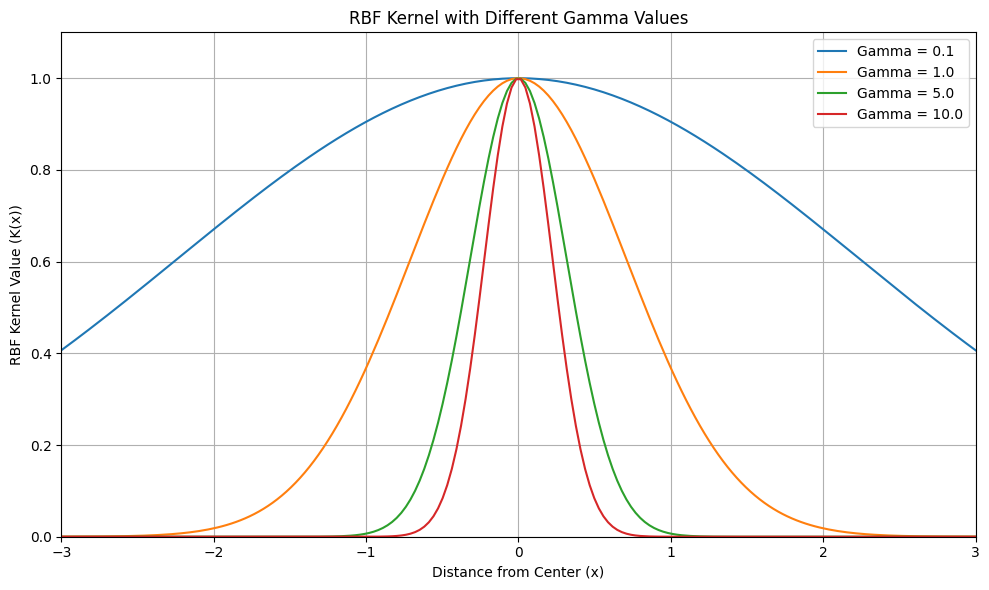

In [1]:
## Plotting different gamma values

def rbf_kernel(x, gamma):
    """
    Calculates the Radial Basis Function (RBF) kernel value.

    Args:
        x:  Distance from the center point.
        gamma: Gamma parameter, controlling the width of the RBF.

    Returns:
        The RBF kernel value.
    """
    return np.exp(-gamma * x**2)

# Define the range of x values to plot
x_values = np.linspace(-3, 3, 200)  # Range from -3 to 3, 200 points

# Define different gamma values to experiment with
gamma_values = [0.1, 1.0, 5.0, 10.0]

# Create the plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed

for gamma in gamma_values:
    rbf_vals = rbf_kernel(x_values, gamma)
    plt.plot(x_values, rbf_vals, label=f'Gamma = {gamma}')

plt.title('RBF Kernel with Different Gamma Values')
plt.xlabel('Distance from Center (x)')
plt.ylabel('RBF Kernel Value (K(x))')
plt.legend()
plt.grid(True) # Add grid for better readability
plt.xlim([-3, 3]) # Set x-axis limits for better focus
plt.ylim([0, 1.1]) # Set y-axis limits to be from 0 to slightly above 1
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [15]:
from flask import Flask, request, jsonify
import pandas as pd
import pickle

app = Flask(__name__)

# Load OneClassSVM model and scaler
oneclass_svm_model = pickle.load(open('oneclass_svm_model.pkl', 'rb'))
data_scaler = pickle.load(open('standard_scaler_oneclasssvm.pkl', 'rb'))

@app.route('/detect_anomaly', methods=['POST'])
def detect_anomaly():
    try:
        data_json = request.get_data()
        if not data_json:
            return jsonify({'error': 'No JSON data provided'}), 400

        input_df = pd.DataFrame([data_json]) # Input data as DataFrame
        input_scaled = data_scaler.transform(input_df) # Scale input data
        prediction = oneclass_svm_model.predict(input_scaled).tolist() # Get prediction

        return jsonify({'prediction': prediction[0]}) # Return single prediction

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True) # debug=True for local testing, remove for production

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1